In [213]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tqdm import tqdm

In [218]:
def erosion(image, kernel):
    """
    Performs erosion on a binary image using a given kernel.
    
    Erosion reduces the foreground (white) regions of the binary image by applying 
    the kernel and only retaining the parts of the image where the entire kernel fits 
    within the foreground.
    
    Parameters:
    image (numpy.ndarray): Binary input image (2D array of 0s and 1s).
    kernel (numpy.ndarray): Kernel used for erosion (2D array of 0s and 1s).
    
    Returns:
    numpy.ndarray: Eroded binary image.
    """
    rows, cols = image.shape
    kernel_rows, kernel_cols = kernel.shape

    # Create an output image with same dimensions
    output = np.zeros_like(image)

    # Iterate over the image
    for i in range(rows - kernel_rows + 1):
        for j in range(cols - kernel_cols + 1):
            # Check if the kernel fits entirely within the image region
            if np.all(image[i:i+kernel_rows, j:j+kernel_cols] >= kernel):
                output[i+kernel_rows//2, j+kernel_cols//2] = 1

    return output


def dilation(image, kernel):
    """
    Performs dilation on a binary image using a given kernel.
    
    Dilation expands the foreground (white) regions of the binary image by applying 
    the kernel and setting the central pixel of the kernel to 1 if any part of the 
    kernel overlaps with the foreground.
    
    Parameters:
    image (numpy.ndarray): Binary input image (2D array of 0s and 1s).
    kernel (numpy.ndarray): Kernel used for dilation (2D array of 0s and 1s).
    
    Returns:
    numpy.ndarray: Dilated binary image.
    """
    image = image.copy()
    output = np.zeros_like(image)

    kernel = np.array(kernel)
    kernel_size = kernel.shape[0]
    img_padded = np.pad(image, kernel_size//2, mode='constant')

    for i in range(kernel_size//2, img_padded.shape[0] - kernel_size//2):
        for j in range(kernel_size//2, img_padded.shape[1] - kernel_size//2):
            output[i-kernel_size//2, j-kernel_size//2] = np.max(img_padded[i-kernel_size//2:i+kernel_size//2 + 1, j-kernel_size//2:j+kernel_size//2 + 1] * kernel)
    return output


def opening(image, kernel):
    """
    Performs opening on a binary image using a given kernel.
    
    Opening is an erosion operation followed by a dilation operation, which helps 
    in removing noise and small objects from the binary image.
    
    Parameters:
    image (numpy.ndarray): Binary input image (2D array of 0s and 1s).
    kernel (numpy.ndarray): Kernel used for both erosion and dilation (2D array of 0s and 1s).
    
    Returns:
    numpy.ndarray: Binary image after opening operation.
    """
    image = image.copy()
    eroded_img = erosion(image, kernel)
    opened_img = dilation(eroded_img, kernel)
    return opened_img


def _dilate_k(image, kernel, k):
    """
    Performs k successive dilation operations on a binary image using a given kernel.
    
    Parameters:
    image (numpy.ndarray): Binary input image (2D array of 0s and 1s).
    kernel (numpy.ndarray): Kernel used for dilation (2D array of 0s and 1s).
    k (int): Number of dilation iterations.
    
    Returns:
    numpy.ndarray: Binary image after k dilations.
    """
    eroded_img = image.copy()
    for _ in range(k):
        eroded_img = dilation(eroded_img, kernel)
    return eroded_img


def find_structure(image, kernel):
    """
    Decomposes a binary image into its structural elements using a given kernel.
    
    This function repeatedly applies erosion and opening operations to extract 
    the different structures within the binary image.
    
    Parameters:
    image (numpy.ndarray): Binary input image (2D array of 0s and 1s).
    kernel (numpy.ndarray): Kernel used for both erosion and opening (2D array of 0s and 1s).
    
    Returns:
    list of numpy.ndarray: List of structural elements found in the image.
    """
    fst_term = image.copy()
    snd_term = opening(fst_term, kernel)
    structures = [fst_term - snd_term]
    while np.any(snd_term == 1):
        fst_term = erosion(fst_term, kernel)
        snd_term = opening(fst_term, kernel)
        structures.append(np.array(fst_term - snd_term))
        if len(structures) % 10 == 0:
            print(f'{len(structures)}th iteration')
    return structures


def find_image(structures, kernel):
    """
    Reconstructs a binary image from its structural elements using a given kernel.
    
    This function applies successive dilations to the structural elements and 
    combines them to reconstruct the original image.
    
    Parameters:
    structures (list of numpy.ndarray): List of structural elements.
    kernel (numpy.ndarray): Kernel used for dilation (2D array of 0s and 1s).
    
    Returns:
    numpy.ndarray: Reconstructed binary image.
    """
    image = np.zeros_like(structures[0])
    for i, s in tqdm(enumerate(structures)):
        s_k = _dilate_k(s, kernel, i)
        image = np.logical_or(image, s_k)
        if i % 10 == 0:
            print(f'{i}th iteration')
    return np.array(image, np.uint8)


def get_structure_image(structures):
    """
    Combines structural elements to form a binary image.
    
    This function combines all structural elements by performing a logical OR 
    operation to generate the final binary image.
    
    Parameters:
    structures (list of numpy.ndarray): List of structural elements.
    
    Returns:
    numpy.ndarray: Combined binary image from structural elements.
    """
    image = np.zeros_like(structures[0])
    for s in tqdm(structures):
        image = np.logical_or(image, s)
    image = np.array(image, np.uint8)
    return image


def show_binary_image(image):
    """
    Converts a binary image to an 8-bit image for display.
    
    This function multiplies the binary image by 255 to convert it into an 
    8-bit image (0s become 0 and 1s become 255) for visualization purposes.
    
    Parameters:
    image (numpy.ndarray): Binary input image (2D array of 0s and 1s).
    
    Returns:
    numpy.ndarray: 8-bit image for display.
    """
    return image * 255

In [215]:
image = np.array([
    [1, 1, 1, 1, 0, 0, 0],
    [1, 1, 1, 1, 0, 0, 0],
    [1, 1, 1, 1, 0, 0, 0],
    [1, 1, 1, 1, 1, 1, 1],
    [1, 1, 1, 1, 1, 1, 1],
    [1, 1, 1, 1, 1, 1, 1],
    [1, 1, 1, 1, 1, 1, 1],
])

kernel = np.array([[0, 1, 0],
                   [1, 1, 1],
                   [0, 1, 0]])

## Image 8.6

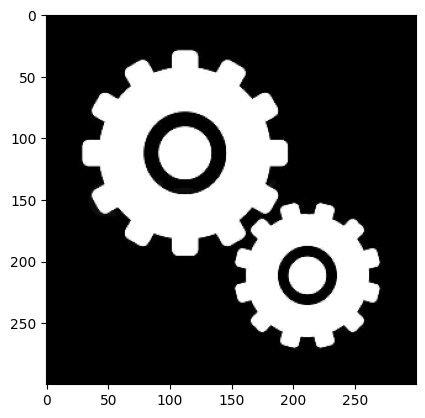

In [222]:
image2 = cv2.imread('q8_6.png', cv2.IMREAD_GRAYSCALE)
image2 = cv2.resize(image2, (300, 300), cv2.INTER_LINEAR) # Resize to speedup process
plt.imshow(image2, 'gray')

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)
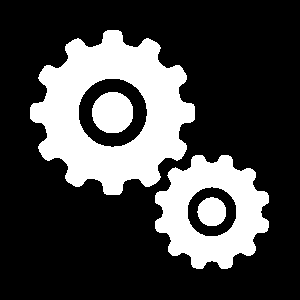

In [223]:
blurred2 = cv2.GaussianBlur(image2, (15, 15), 0)
blurred2[blurred2<=150] = 0
blurred2[blurred2>150] = 1
show_binary_image(blurred2)

In [224]:
structures2 = find_structure(blurred2, kernel)

10th iteration
20th iteration


100%|██████████| 25/25 [00:00<00:00, 12232.57it/s]


array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)
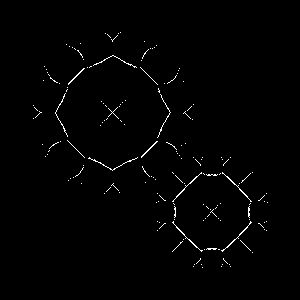

In [225]:
get_structure_image(structures2) * 255

In [226]:
recovered_img = find_image(structures2, kernel)

0it [00:00, ?it/s]

0th iteration


11it [00:42,  5.97s/it]

10th iteration


21it [03:09, 17.80s/it]

20th iteration


25it [04:36, 11.05s/it]


array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)
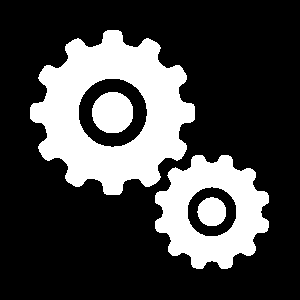

In [227]:
show_binary_image(recovered_img)

## Image 8.5

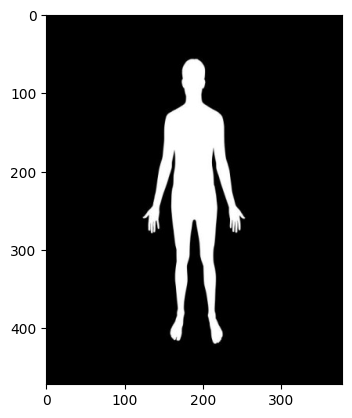

In [270]:
image1 = cv2.imread('q8_5.jpg', cv2.IMREAD_GRAYSCALE)
# image1 = cv2.resize(image1, (image1.shape[0]//2, image1.shape[1]//2), cv2.INTER_LINEAR) # Resize to speedup process
plt.imshow(image1, 'gray')

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)
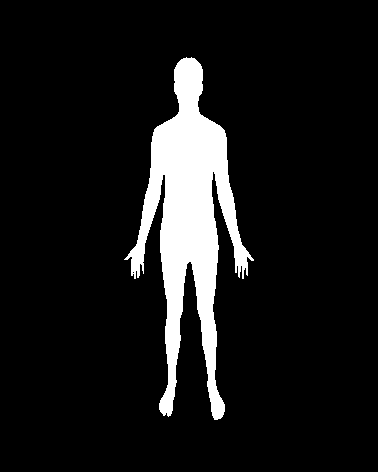

In [271]:
image1[image1<=160] = 0
image1[image1>160] = 1
show_binary_image(image1)

10th iteration
20th iteration
30th iteration


100%|██████████| 38/38 [00:00<00:00, 10901.75it/s]


array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)
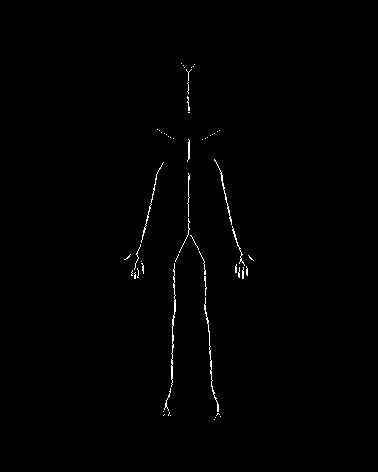

In [272]:
structures1 = find_structure(image1, kernel)
get_structure_image(structures1) * 255

0it [00:00, ?it/s]

0th iteration


11it [01:25, 11.86s/it]

10th iteration


21it [05:19, 26.79s/it]

20th iteration


31it [11:42, 41.12s/it]

30th iteration


38it [17:34, 27.75s/it]


array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)
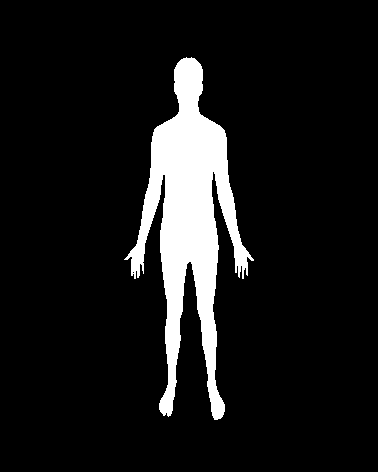

In [273]:
recovered_img1 = find_image(structures1, kernel)
show_binary_image(recovered_img1)

## Image 8.7

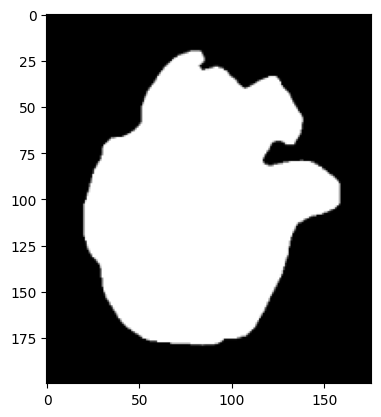

In [274]:
image3 = cv2.imread('q8_7.png', cv2.IMREAD_GRAYSCALE)
# image3 = cv2.resize(image3, (image3.shape[0]//2, image3.shape[1]//2), cv2.INTER_LINEAR) # Resize to speedup process
plt.imshow(image3, 'gray')

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)
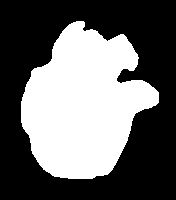

In [275]:
image3[image3<=160] = 0
image3[image3>160] = 1
show_binary_image(image3)

10th iteration
20th iteration
30th iteration
40th iteration
50th iteration
60th iteration


100%|██████████| 61/61 [00:00<00:00, 23985.43it/s]


array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)
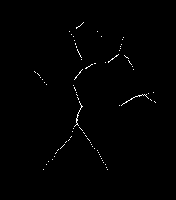

In [276]:
structures3 = find_structure(image3, kernel)
get_structure_image(structures3) * 255

0it [00:00, ?it/s]

0th iteration


11it [00:16,  2.40s/it]

10th iteration


21it [01:02,  5.27s/it]

20th iteration


31it [02:18,  8.08s/it]

30th iteration


41it [04:04, 11.05s/it]

40th iteration


51it [06:21, 14.35s/it]

50th iteration


61it [09:06,  8.95s/it]

60th iteration


array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)
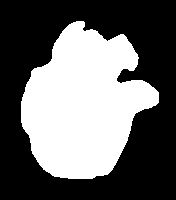

In [277]:
recovered_img3 = find_image(structures3, kernel)
show_binary_image(recovered_img3)